In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

books = pd.read_csv("data/books.csv",  encoding="latin-1", error_bad_lines=False)
users = pd.read_csv("data/users.csv",  encoding="latin-1", error_bad_lines=False)
ratings = pd.read_csv("data/ratings.csv",  encoding="latin-1", error_bad_lines=False)


C:\Users\shade\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
books.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
users.rename(columns = {'User-ID':'user_id', 'Location':'location', 'Age':'age'}, inplace=True)
ratings.rename(columns = {'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       271360 non-null  object
 1   title      271360 non-null  object
 2   author     271359 non-null  object
 3   year       271360 non-null  object
 4   publisher  271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  int64 
 1   ISBN     1149780 non-null  object
 2   rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## Clean data

In [6]:
books.loc[books.year == 'DK Publishing Inc', :]

,ISBN,title,author,year,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [7]:
books.loc[books.ISBN =='0789466953', 'year']=2000
books.loc[books.ISBN =='0789466953', 'author']= "James Buckly"
books.loc[books.ISBN =='0789466953', 'publisher']= "DK Publishing Inc"
books.loc[books.ISBN =='0789466953', 'title']= "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [8]:
books.loc[books.ISBN =='078946697X', 'year']=2000
books.loc[books.ISBN =='078946697X', 'author']= "Michael Teitelbaum"
books.loc[books.ISBN =='078946697X', 'publisher']= "DK Publishing Inc"
books.loc[books.ISBN =='078946697X', 'title']= "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [9]:
books.loc[books.year=="Gallimard",:]

,ISBN,title,author,year,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [10]:
books.loc[books.ISBN =='2070426769', 'year']=2003
books.loc[books.ISBN =='2070426769', 'author']= "Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio"
books.loc[books.ISBN =='2070426769', 'publisher']= "Gallimard"
books.loc[books.ISBN =='2070426769', 'title']= "Peuple du ciel, suivi de 'Les Bergers"

In [11]:
books.loc[books.publisher.isnull()]

,ISBN,title,author,year,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [12]:
books.loc[books.ISBN=='193169656X','publisher']='other'

In [13]:
## Extract users and ratings of more than 200

In [14]:
x = ratings['user_id'].value_counts() > 200
y = x[x].index  #user_ids
print(y.shape)
ratings = ratings[ratings['user_id'].isin(y)]

(899,)


In [15]:
## Merge ratings with books

In [16]:
rating_with_books = ratings.merge(books, on='ISBN')
columns=['publisher','year']
rating_with_books=rating_with_books.drop(columns, axis=1)
rating_with_books.head()

,user_id,ISBN,rating,title,author
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner


In [17]:
type(rating_with_books)

pandas.core.frame.DataFrame

In [18]:
#rating_with_books.to_csv('./data/df.csv')

In [19]:
## Find popular books

In [20]:
rating_with_books = rating_with_books.dropna(axis = 0, subset = ['title']) 

In [21]:
rating_with_booksCount=(rating_with_books.
                        groupby(by= ['title'])['rating'].
                        count ().
                        reset_index().
                        rename(columns={'rating': 'totalRatingCount'})
                        [['title', 'totalRatingCount']]
                       )
rating_with_booksCount.head()


,title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [22]:
rating_with_totalRatingCount=rating_with_books.merge(rating_with_booksCount, left_on ='title', right_on='title')
rating_with_totalRatingCount.head()

,user_id,ISBN,rating,title,author,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82


In [23]:
## the books was big for memory and i was can not to work with it then i decied to choose 50 popular books?????????????????

In [24]:
popular_threshold=50
rating_popular_book=rating_with_totalRatingCount.query('totalRatingCount >= @popular_threshold')
rating_popular_book.head()

,user_id,ISBN,rating,title,author,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,82


## Extract books that have received more than 50 ratings.

The data was very large, which represented a great challenge to me and I was trying to enter it into the model,
 but an error appeared to me memory error (out of Index)
The problem was solved by extracting books that have received more than 50 ratings

In [25]:
number_rating = rating_with_books.groupby('title')['rating'].count().reset_index()
number_rating.rename(columns= {'rating':'number_of_ratings'}, inplace=True)

In [26]:
final_rating = rating_with_books.merge(number_rating, on='title')
final_rating.shape

(487671, 6)

In [27]:
final_rating = final_rating[final_rating['number_of_ratings'] >= 50]
final_rating.drop_duplicates(['user_id','title'], inplace=True)

In [28]:
final_rating.columns

Index(['user_id', 'ISBN', 'rating', 'title', 'author', 'number_of_ratings'], dtype='object')

Top rated book titles

In [29]:
top_title_count = pd.DataFrame(final_rating.groupby('title')['rating'].count())
top_title_count.sort_values('rating', ascending=False).head()

,rating
title,
Wild Animus,363
The Lovely Bones: A Novel,270
Bridget Jones's Diary,236
The Pelican Brief,228
Divine Secrets of the Ya-Ya Sisterhood: A Novel,225


In [30]:
# final rating contains book recieved more than 50 ratings

In [31]:
#title_u=final_rating['title'].unique()
#title_u

## Data visualization

C:\Users\shade\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


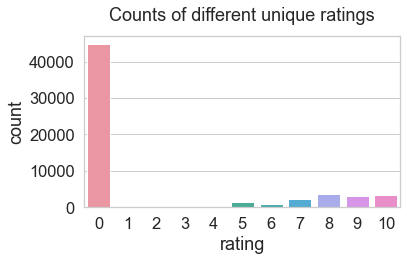

In [32]:
#Number of Rate score
sns.set(font_scale=1.5, style='whitegrid')
sns.countplot(final_rating['rating'])
plt.title('Counts of different unique ratings', y=1.05)
plt.tight_layout()
plt.savefig('Rate.png', bbox_inches='tight')

In [33]:
## As we can see in the above ## As we can see in the above graph, there are a lot of ratings with zeros 
## and this is not good because there are many books that are not rated yetdiagram there is a lot of ratings with zeros 
##and that is not good because there is many books 

In [34]:
## I will remove the books without rating

In [35]:
final_rating=final_rating[final_rating['rating'] != 0]

C:\Users\shade\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


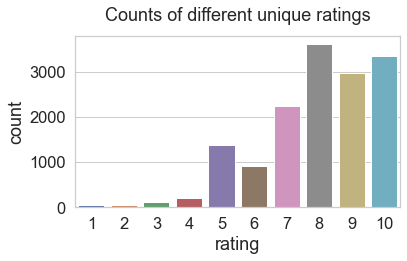

In [36]:
#Number of Rate score
sns.set(font_scale=1.5, style='whitegrid')
sns.countplot(final_rating['rating'])
plt.title('Counts of different unique ratings', y=1.05)
plt.tight_layout()
#plt.savefig('Rate.png', bbox_inches='tight')

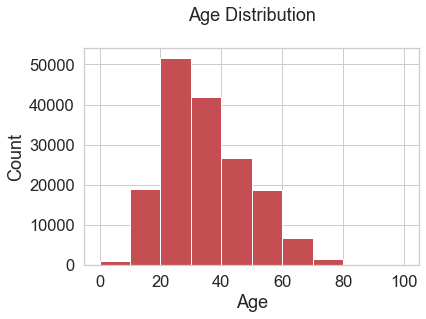

In [37]:
# from the diagram we observed the most readers are between 20-30 years
users.age.hist(bins=[0,10, 20, 30, 40, 50,60,70,80,90,100],color="r")
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

In [38]:
## what is the most popular book with high rating value?

In [39]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['rating'].count())
rating_count.sort_values('rating', ascending=False).head()

,rating
ISBN,
0971880107,363
0316666343,270
0060928336,220
0440214041,218
0385504209,215


In [40]:
popular_book = pd.merge(rating_count, books, on='ISBN')
popular_book=popular_book.head()
popular_book

,ISBN,rating,title,author,year,publisher
0,0000913154,1,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
1,0001010565,1,Mog's Christmas,Judith Kerr,1992,Collins
2,0001046438,1,Liar,Stephen Fry,0,Harpercollins Uk
3,000104687X,1,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
4,0001047213,1,The Fighting Man,Gerald Seymour,1993,HarperCollins Publishers


In [41]:
## I want to know the order of the books to know the highst book and the lowest number of books for each title 
## As we can see from the below diagram the highst book was "The Lovely Bones: A Novel"  

In [42]:
top_ten_book=final_rating.sort_values('ISBN')[['title']].value_counts().to_frame().rename(
         columns={0:'book_counts'}).reset_index()
top_ten_book=top_ten_book.head(10)

In [43]:
top_ten_book

,title,book_counts
0,The Lovely Bones: A Novel,104
1,Bridget Jones's Diary,84
2,The Da Vinci Code,82
3,Harry Potter and the Chamber of Secrets (Book 2),75
4,To Kill a Mockingbird,73
5,Harry Potter and the Sorcerer's Stone (Harry P...,66
6,Harry Potter and the Prisoner of Azkaban (Book 3),66
7,The Red Tent (Bestselling Backlist),62
8,Good in Bed,61
9,The Secret Life of Bees,61


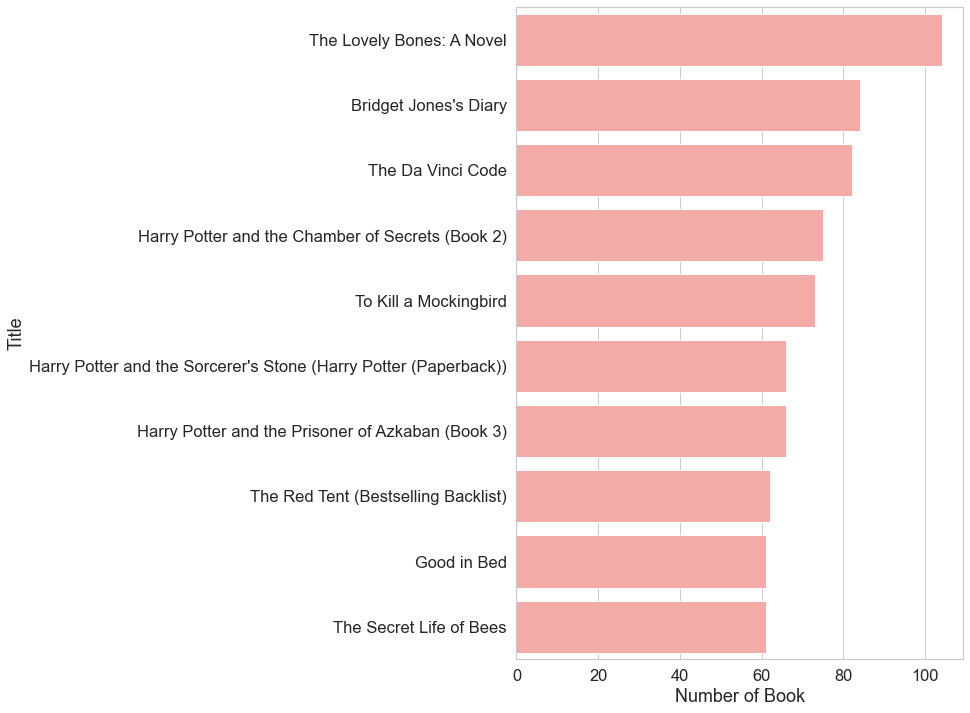

In [44]:
#Top books rated by users 
f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes("pastel")
sns.set_style("white")
sns.barplot(x=top_ten_book['book_counts'], y=top_ten_book['title'], data=top_ten_book, color='r')
ax.set(ylabel='Title',xlabel="Number of Book")
plt.savefig('author_number_books.png', bbox_inches='tight')

In [45]:
top_ten_book_author=final_rating.sort_values('title')[['author']].value_counts().to_frame().rename(
         columns={0:'book_counts'}).reset_index()
top_ten_book_author=top_ten_book_author.head(10)

In [46]:
top_ten_book_author

,author,book_counts
0,Stephen King,810
1,Nora Roberts,519
2,John Grisham,451
3,James Patterson,401
4,Janet Evanovich,367
5,J. K. Rowling,352
6,Sue Grafton,330
7,Mary Higgins Clark,257
8,Dean R. Koontz,243
9,JOHN GRISHAM,222


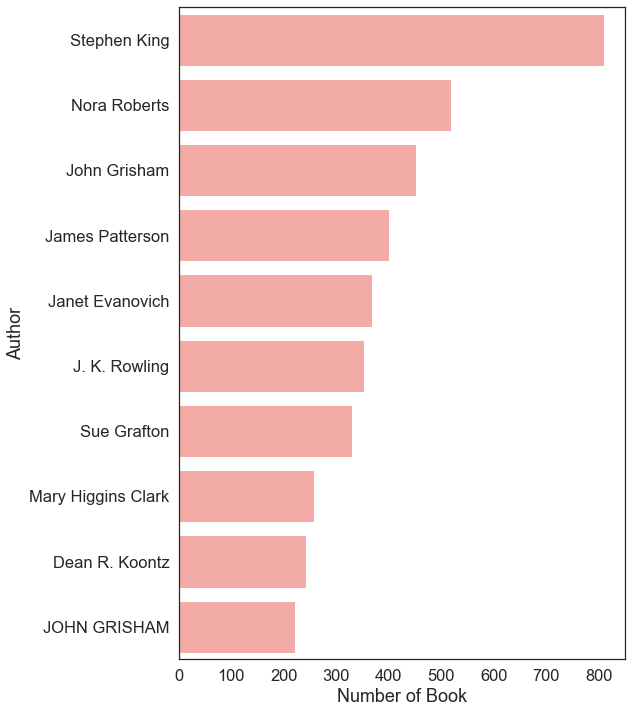

In [47]:
#Highest number of books per author 
f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes("pastel")
sns.set_style("white")
sns.barplot(x=top_ten_book_author['book_counts'], y=top_ten_book_author['author'], data=top_ten_book_author, color='r')
ax.set(ylabel='Author',xlabel="Number of Book")
plt.savefig('Courses.png', bbox_inches='tight')

### The book with highst ratings

In [48]:
top_book_rating=final_rating.sort_values('ISBN')[['title']].value_counts().to_frame().rename(
         columns={0:'rating_counts'}).reset_index()
top_book_rating=top_book_rating.head(10)

In [49]:
top_book_rating

,title,rating_counts
0,The Lovely Bones: A Novel,104
1,Bridget Jones's Diary,84
2,The Da Vinci Code,82
3,Harry Potter and the Chamber of Secrets (Book 2),75
4,To Kill a Mockingbird,73
5,Harry Potter and the Sorcerer's Stone (Harry P...,66
6,Harry Potter and the Prisoner of Azkaban (Book 3),66
7,The Red Tent (Bestselling Backlist),62
8,Good in Bed,61
9,The Secret Life of Bees,61


## Create Pivot Table

In [50]:
book_pivot = final_rating.pivot_table(columns='user_id', index='title', values="rating")
book_pivot.fillna(0, inplace=True)

In [51]:
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,273979,274004,274061,274301,274308,274808,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
book_pivot.iloc[0, :]

user_id
254       9.0
2276      0.0
2766      0.0
2977      0.0
3363      0.0
         ... 
274808    0.0
275970    0.0
277427    0.0
277639    0.0
278418    0.0
Name: 1984, Length: 839, dtype: float64

## Buliding the model

### Recommendation Systems : User-based Collaborative Filtering using nearest neighbors algorithm

In [53]:
#Convert the pivot to matrix 
book_sparse = csr_matrix(book_pivot)
book_sparse

<742x839 sparse matrix of type '<class 'numpy.float64'>'
	with 14942 stored elements in Compressed Sparse Row format>

class sklearn.neighbors.NearestNeighbors(n_neighbors=5, radius=1.0, algorithm='auto', leaf_size=30, warn_on_equidistant=True)

In [54]:
model = NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [55]:
book_pivot.iloc[0, :]

user_id
254       9.0
2276      0.0
2766      0.0
2977      0.0
3363      0.0
         ... 
274808    0.0
275970    0.0
277427    0.0
277639    0.0
278418    0.0
Name: 1984, Length: 839, dtype: float64

In [56]:
book_pivot.iloc[2, :]

user_id
254        0.0
2276      10.0
2766       0.0
2977       0.0
3363       0.0
          ... 
274808     0.0
275970     0.0
277427     0.0
277639     0.0
278418     0.0
Name: 2nd Chance, Length: 839, dtype: float64

In [57]:
book_pivot.tail()

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,273979,274004,274061,274301,274308,274808,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zoya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\O\"" Is for Outlaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
book_pivot.head()

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,273979,274004,274061,274301,274308,274808,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


In [59]:
#book_pivot.to_excel('./data/book_pivot.xlsx')

In [60]:
book_pivot[(book_pivot.T != 0.0).any()].head()

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,273979,274004,274061,274301,274308,274808,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


In [61]:
book1=book_pivot[book_pivot[254] != 0]
book1

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,273979,274004,274061,274301,274308,274808,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Gods,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Animal Farm,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Harry Potter and the Chamber of Secrets (Book 2),9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,0.0,9.0,0.0,0.0,0.0
Harry Potter and the Goblet of Fire (Book 4),9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Harry Potter and the Prisoner of Azkaban (Book 3),9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Harry Potter and the Sorcerer's Stone (Book 1),9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
She's Come Undone (Oprah's Book Club),7.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Bonesetter's Daughter,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
book1=book_pivot[book_pivot[254] != 0]
print(book1)

user_id                                             254     2276    2766    \
title                                                                        
1984                                                   9.0     0.0     0.0   
American Gods                                         10.0     0.0     0.0   
Animal Farm                                            8.0     0.0     0.0   
Harry Potter and the Chamber of Secrets (Book 2)       9.0     0.0     0.0   
Harry Potter and the Goblet of Fire (Book 4)           9.0     0.0     0.0   
Harry Potter and the Prisoner of Azkaban (Book 3)      9.0     0.0     0.0   
Harry Potter and the Sorcerer's Stone (Book 1)         9.0     0.0     0.0   
She's Come Undone (Oprah's Book Club)                  7.0     0.0     0.0   
The Bonesetter's Daughter                              9.0     0.0     0.0   
The Dark Half                                          8.0     0.0     0.0   
The Fellowship of the Ring (The Lord of the Rin...     8.0     0

In [63]:
book1=book_pivot[book_pivot[6251] != 0]
print(book1)

user_id                                             254     2276    2766    \
title                                                                        
A Heartbreaking Work of Staggering Genius              0.0     0.0     0.0   
A Wrinkle In Time                                      0.0     0.0     0.0   
A Wrinkle in Time                                      0.0     0.0     0.0   
A Year in Provence                                     0.0     0.0     0.0   
American Gods                                         10.0     0.0     0.0   
Angela's Ashes: A Memoir                               0.0     0.0     0.0   
Artemis Fowl (Artemis Fowl, Book 1)                    0.0     0.0     0.0   
Coraline                                               0.0     0.0     0.0   
Dude, Where's My Country?                              0.0     0.0     0.0   
Dying for Chocolate (Culinary Mysteries (Paperb...     0.0     0.0     0.0   
Good Omens                                             0.0     0

## The result 

Search for book index of the the book title

In [71]:
distances, suggestions = model.kneighbors(book_pivot.iloc[240, :].values.reshape(1, -1))

In [72]:
distances

array([[ 0.        , 61.20457499, 68.78953409, 71.36525765, 73.17786551]])

In [73]:
suggestions

array([[240, 238, 237, 241, 239]], dtype=int64)

In [74]:
for i in range(len(suggestions)):
    print(book_pivot.index[suggestions[i]])

Index(['Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Sorcerer's Stone (Book 1)',
       'Harry Potter and the Order of the Phoenix (Book 5)'],
      dtype='object', name='title')


Search by using the title name of the book

In [77]:
distances1, suggestions1 = model.kneighbors(book_pivot.loc['Harry Potter and the Order of the Phoenix (Book 5)', :].values.reshape(1, -1))

In [79]:
for i in range(len(suggestions1)):
    print(book_pivot.index[suggestions1[i]])

Index(['Harry Potter and the Order of the Phoenix (Book 5)',
       'Harry Potter and the Goblet of Fire (Book 4)', 'No Safe Place',
       'Journey', 'Tough Cookie'],
      dtype='object', name='title')
